In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt
import pickle
from matplotlib import cm
import pylab
from PIL import Image
from matplotlib.pyplot import imshow
import boto3
from botocore.handlers import disable_signing

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 

In [3]:
import keras
from keras import layers, regularizers,optimizers,callbacks,applications
from keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import SGD,Adam
from keras.layers import Dropout,Conv2D,MaxPool2D
from keras import models
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [4]:
import s3fs

fs = s3fs.S3FileSystem()
folder_names=fs.ls('s3://musicclassification')
file_names=[]
for i in range(1,len(folder_names)):
    file_names+=fs.ls(folder_names[i]) 

In [5]:
label_match=pd.read_csv('s3://musicclassification/label_match.csv')
label_match['code']=label_match.code.astype(str).str.zfill(8)
label_match = dict(zip(label_match.code, label_match.label))

In [6]:
img_dir =r'spec_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 8
NUM_EPOCHS = 10
BATCH_SIZE = 64
L2_LAMBDA = 0.001

In [7]:
label_dict = {'Electronic':0,'Experimental':1,'Folk':2,'Hip-Hop':3,'Instrumental':4,
              'International':5,'Pop':6,'Rock':7 }

In [8]:
label_array = []
for file_ in file_names:
    if file_.endswith(".jpg"):
        vals = file_[-12:-4]
        lab=label_match[vals]
        label_array.append(label_dict[lab])
        
label_array=np.array(label_array).reshape(-1, 1)
one_hot = OneHotEncoder()

In [9]:
train_files, test_files, train_labels, test_labels = train_test_split(file_names, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1)

val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5)

In [10]:
train_files,train_labels=shuffle(train_files,train_labels)

In [11]:
conv_base = keras.applications.VGG16(include_top = False, 
                                            weights = 'imagenet', 
                                            input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 channels - RGB
                                           ) 

In [12]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

# 1-layer MLP with Dropout, BN 
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 8)                 4104      
Total params: 24,156,488
T

In [13]:
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 8)                 4104      
Total params: 24,156,488
Trainable params: 9,441,800
Non-trainable params: 14,714,688
________________________________________________________

In [14]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        if file_.endswith(".jpg"):
            with fs.open("s3://"+file_) as f:
                im=Image.open(f)
                im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
                img_array.append(np.array(im))

                vals = file_[-12:-4]
                idx_array.append(vals)
                lab=label_match[vals]
                label_array.append(label_dict[lab])
    
    label_array=np.array(label_array).reshape(-1,1)
    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [15]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)
            if batch_label_array.shape[1]==8: 
                yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [16]:
optimizer = optimizers.Adam(lr=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/transfer_learning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE
history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
449/449 [==============================] - 1796s 4s/step - loss: 2.6284 - categorical_accuracy: 0.3546 - val_loss: 2.3947 - val_categorical_accuracy: 0.4206
Epoch 2/10
449/449 [==============================] - 1640s 4s/step - loss: 2.2696 - categorical_accuracy: 0.4455 - val_loss: 2.2161 - val_categorical_accuracy: 0.4463
Epoch 3/10
449/449 [==============================] - 1605s 4s/step - loss: 2.1056 - categorical_accuracy: 0.4667 - val_loss: 2.1051 - val_categorical_accuracy: 0.4606
Epoch 4/10
449/449 [==============================] - 1589s 4s/step - loss: 2.0000 - categorical_accuracy: 0.4874 - val_loss: 2.0339 - val_categorical_accuracy: 0.4736
Epoch 5/10
449/449 [==============================] - 1589s 4s/step - loss: 1.9241 - categorical_accuracy: 0.4988 - val_loss: 1.9859 - val_categorical_accuracy: 0.4827
Epoch 6/10
449/449 [==============================] - 1580s 4s/s

In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 64
L2_LAMBDA = 0.001
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

# 1-layer MLP with Dropout, BN 
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.2, name='dropout_1')) 
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
conv_base.trainable = True
optimizer = optimizers.Adam(lr=1e-5)

tl_model = models.load_model(filepath='saved_models/transfer_learning_epoch_10_0.4990.h5') # 02 is epoch 3
tl_model.weights[-4:] 

for i in range(1, len(model.layers)): # The first layer (index = 0) is the conv base
    model.layers[i].set_weights(tl_model.layers[i].get_weights())
    
loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/fine_tuning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [17]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE
history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                             )

Epoch 1/10
449/449 [==============================] - 1638s 4s/step - loss: 1.6284 - categorical_accuracy: 0.5632 - val_loss: 1.7200 - val_categorical_accuracy: 0.5443
Epoch 2/10
449/449 [==============================] - 1587s 4s/step - loss: 1.4425 - categorical_accuracy: 0.6313 - val_loss: 1.6965 - val_categorical_accuracy: 0.5590
Epoch 3/10
449/449 [==============================] - 1581s 4s/step - loss: 1.2618 - categorical_accuracy: 0.6976 - val_loss: 1.7087 - val_categorical_accuracy: 0.5590
Epoch 4/10
449/449 [==============================] - 1579s 4s/step - loss: 1.0737 - categorical_accuracy: 0.7657 - val_loss: 1.8104 - val_categorical_accuracy: 0.5590
Epoch 5/10
449/449 [==============================] - 1590s 4s/step - loss: 0.9151 - categorical_accuracy: 0.8221 - val_loss: 1.8846 - val_categorical_accuracy: 0.5401
Epoch 6/10
449/449 [==============================] - 1618s 4s/step - loss: 0.8026 - categorical_accuracy: 0.8585 - val_loss: 2.0676 - val_categorical_accuracy:

In [18]:
#Save scores on train and validation sets
with open('pickle_files/fine_tuning_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [20]:
# Load scores
with open('pickle_files/fine_tuning_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

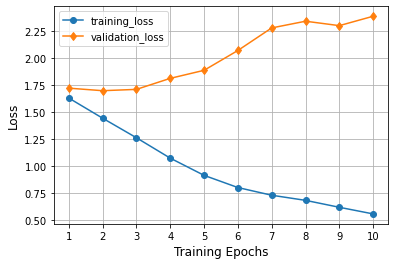

In [7]:
plt.xticks(range(1,11))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

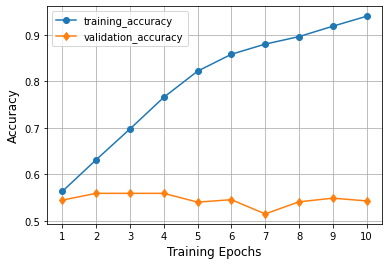

In [8]:
plt.xticks(range(1,11))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

In [21]:
model = models.load_model('saved_models/fine_tuning_epoch_02_0.5590.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [22]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

In [24]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[133  17   4  16  17  10   8   2]
 [ 16  79  16  11  27  22   9  15]
 [  5   9 110   6  23  17   8  11]
 [ 21   7   2 151   5   6   3   1]
 [ 11  15  22   1 110  14   9   7]
 [ 23   6   9  10   9 112   8   5]
 [ 29  19  17  14  18  38  44  27]
 [  6   9  11   1  15   9  10 111]]


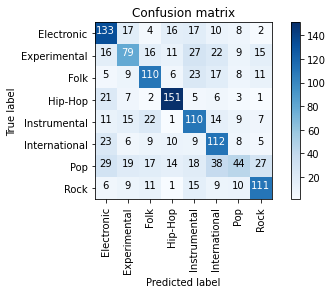

In [25]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), classes=label_dict.keys())

In [27]:
accuracy_score(pred,test_labels[:len(pred)])

0.5533854166666666